In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,8)

In [2]:
def kelly_criterion(odd, margin):
    p = 1/odd - margin
    q = 1 - p
    w = p - q/odd
    return w

In [3]:
championship = 'PL'
odds = ['B365H',
     'B365D',
     'B365A',
     'BWH',
     'BWD',
     'BWA',
     'IWH',
     'IWD',
     'IWA',
     'PSH',
     'PSD',
     'PSA',
     'WHH',
     'WHD',
     'WHA',
     'VCH',
     'VCD',
     'VCA',
     'PSCH',
     'PSCD',
     'PSCA']
data1 = pd.read_csv(championship+'2013.csv')
data1=data1[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
data1.index = pd.to_datetime(data1.Date, format = '%d/%m/%y')
data2 = pd.read_csv(championship+'2014.csv')
data2=data2[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
data2.index = pd.to_datetime(data2.Date, format = '%d/%m/%y')
data = pd.concat([data1, data2], axis = 0)
for years in np.arange(2015, 2017):
    subdata = pd.read_csv(championship+str(years)+'.csv')
    subdata=subdata[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
    subdata.index = pd.to_datetime(subdata.Date, format='%d/%m/%y')
    data = pd.concat([data, subdata], axis=0)
for years in np.arange(2017,2020):
    subdata = pd.read_csv(championship+str(years)+'.csv')
    subdata=subdata[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
    subdata.index = pd.to_datetime(subdata.Date, format='%d/%m/%Y')
    data = pd.concat([data, subdata], axis=0)
    
    
    

In [16]:
def import_data(ticker, start_date, end_date):
    import yfinance as yf
    data = yf.Ticker(ticker)
    data = data.history(period="max")
    data['Return'] = data['Close'].pct_change()
    data = data.loc[data.index >= start_date]
    data = data.loc[data.index <= end_date]
    
    return data


def betting_strategy(championship, init_capital, max_odd, strategy, weight, a, max_loss, margin):
    import matplotlib.ticker as mtick
    
    odds = ['B365H',
     'B365D',
     'B365A',
     'BWH',
     'BWD',
     'BWA',
     'IWH',
     'IWD',
     'IWA',
     'PSH',
     'PSD',
     'PSA',
     'WHH',
     'WHD',
     'WHA',
     'VCH',
     'VCD',
     'VCA',
     'PSCH',
     'PSCD',
     'PSCA']
    data1 = pd.read_csv(championship+'2013.csv')
    data1=data1[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
    data1.index = pd.to_datetime(data1.Date, format = '%d/%m/%y')
    data2 = pd.read_csv(championship+'2014.csv')
    data2=data2[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
    data2.index = pd.to_datetime(data2.Date, format = '%d/%m/%y')
    data = pd.concat([data1, data2], axis = 0)
    for years in np.arange(2015, 2017):
        subdata = pd.read_csv(championship+str(years)+'.csv')
        subdata=subdata[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
        subdata.index = pd.to_datetime(subdata.Date, format='%d/%m/%y')
        data = pd.concat([data, subdata], axis=0)
    for years in np.arange(2017,2020):
        subdata = pd.read_csv(championship+str(years)+'.csv')
        subdata=subdata[['Date', 'HomeTeam', 'AwayTeam', 'FTR']+odds]
        subdata.index = pd.to_datetime(subdata.Date, format='%d/%m/%Y')
        data = pd.concat([data, subdata], axis=0)
        
    df = data
    
    
    returns = []
    gains = []
    bankroll = [init_capital]
    for i in range(len(df)):
        bookies = ['B365H', 'BWH', 'IWH', 'PSH', 'WHH', 'VCH', 'PSCH']
        idx=np.argmax(df[bookies].iloc[i].values)
        best_bookie=bookies[idx]
        best_odd = max(df[bookies].iloc[i])
        bookies.remove(best_bookie)
        av_odd = df[bookies].iloc[i].mean()
        if (best_odd >= av_odd + margin) & (best_odd <= max_odd):
            if strategy == 'Constant':
                w = weight
            elif strategy == 'Varying':
                w = a * (best_odd - av_odd)/av_odd
            elif strategy == 'Kelly':
                w = kelly_criterion(av_odd, margin) * weight
                #w = max(0,w)
                #w = min(w,1)
            mise = w * bankroll[i]
        else:
            mise = 0
        home_team = df.HomeTeam.iloc[i]
        away_team = df.AwayTeam.iloc[i]
        date = df.index[i]
        result = df.FTR.iloc[i]
        if result == 'H':
            gain = mise*(best_odd-1)
        else:
            gain = -mise
        if mise !=0:
            returns.append(gain/mise)
        else:
            returns.append(0)
        if bankroll[i] > (1-max_loss)*init_capital:
            cum_gain = gain+bankroll[i]
            bankroll.append(cum_gain)
            gains.extend((date, home_team, away_team, result, mise, best_odd, av_odd, gain))
        else:
            break
    n = int(len(gains)/8)
    gains = np.array(gains).reshape((n,8))
    gains = pd.DataFrame(gains, columns=['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'Mise', 'Cote', 'Med Odd','Gain'])
    for columns in ['Cote', 'Med Odd','Gain']:
        gains[columns]=gains[columns].astype('float')
    
    ROI = (bankroll[-1] - bankroll[0]) / bankroll[0]
    bankroll = pd.DataFrame(bankroll[:-1], columns=['Bankroll'])
    bankroll.index = gains.Date
    returns = pd.DataFrame(returns, columns=['Return per bet'])
    returns.index = bankroll.index
    
    cum_gains = []
    for i in range(len(bankroll)):
        cum_gains.append((bankroll['Bankroll'].iloc[i]-init_capital)/init_capital)
    
    bankroll['Betting Strategy Cum. Returns'] = cum_gains
    cum_bets = bankroll[['Betting Strategy Cum. Returns']].groupby(bankroll.index).last()
    
    vol = np.std(returns)
    mean_return = np.mean(returns)
    
    init_date = str(bankroll.index[0])[0:10]
    
    sp = import_data('^GSPC', init_date, '2020-01-01')[['Return']]
    sp_cum_return = pd.DataFrame(data=np.cumprod(1 + sp['Return'].values) - 1, columns=['SP500 Cum. Returns'])
    sp_cum_return.index = sp.index
    
    cum_returns = pd.merge(cum_bets, sp_cum_return, on='Date', how='right')
    
    cum_returns.dropna(inplace=True)
    
    return returns, cum_returns

SP500 Sharpe Ratio: 1.7884169543460091  Betting Sharpe Ratio: 1.8981933729297018 



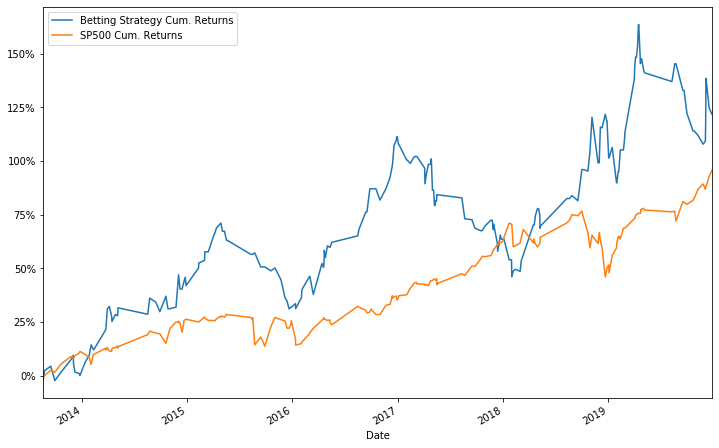

In [17]:
import matplotlib.ticker as mtick
returns, cum_returns = betting_strategy(championship='PL', init_capital=1000, max_odd=1.8, strategy='Varying', weight=5, a=0.75, max_loss=0.3, margin=0.03)
market_sharpe = cum_returns['SP500 Cum. Returns'].mean() / cum_returns['SP500 Cum. Returns'].std()
betting_sharpe = cum_returns['Betting Strategy Cum. Returns'].mean() / cum_returns['Betting Strategy Cum. Returns'].std()
print('SP500 Sharpe Ratio: ' + str(market_sharpe), ' Betting Sharpe Ratio: ' + str(betting_sharpe), '\n')
plt_returns = cum_returns.plot()
plt_returns.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [18]:
returns

,Return per bet
Date,
2013-08-17,-1.00
2013-08-17,0.00
2013-08-17,0.00
2013-08-17,0.00
2013-08-17,0.00
2013-08-17,0.00
2013-08-17,0.00
2013-08-18,0.00
2013-08-18,0.00


In [8]:
returns.corr()

,Betting Strategy Cum. Returns,SP500 Cum. Returns
Betting Strategy Cum. Returns,1.000000,0.834085
SP500 Cum. Returns,0.834085,1.000000


SP500 Sharpe Ratio: 1.7884169543460091  Betting Sharpe Ratio: 1.1933885859788083 



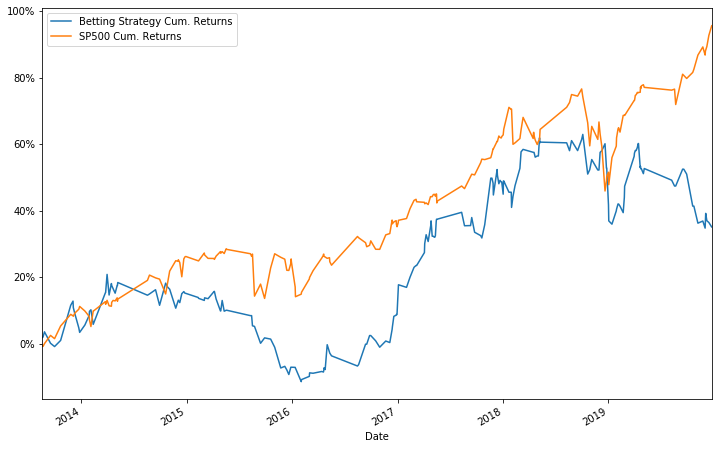

In [7]:
import matplotlib.ticker as mtick
returns = betting_strategy(championship='PL', init_capital=1000, max_odd=2.5, strategy='Varying', weight=5, a=0.2, max_loss=0.3, margin=0.03)
market_sharpe = returns['SP500 Cum. Returns'].mean() / returns['SP500 Cum. Returns'].std()
betting_sharpe = returns['Betting Strategy Cum. Returns'].mean() / returns['Betting Strategy Cum. Returns'].std()
print('SP500 Sharpe Ratio: ' + str(market_sharpe), ' Betting Sharpe Ratio: ' + str(betting_sharpe), '\n')
plt_returns = returns.plot()
plt_returns.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [207]:
returns = pd.merge(cum_bets, sp_cum_return, on='Date', how='right').dropna()

In [195]:
returns.head()

,Betting Strategy Cum. Returns,SP500 Cum. Returns
Date,,
2013-08-19,-0.013761,-0.005900
2013-08-21,-0.007807,-0.007869
2013-08-26,0.035685,0.000574
2013-09-16,0.059046,0.025226
2013-09-30,-0.009340,0.015533


In [196]:
returns['SP500 Cum. Returns'].std()

0.2416424272708159

In [208]:
returns['Betting Strategy Cum. Returns'].std()

0.3833739773478653

In [198]:
returns['SP500 Cum. Returns'].mean()

0.4321574138204496

In [209]:
returns['Betting Strategy Cum. Returns'].mean()

0.7277179431554196

In [200]:
0.79/0.42

1.8809523809523812

In [201]:
0.43/0.24

1.7916666666666667

In [173]:
ROI, vol, mean_return, gains, bankroll = betting_strategy(championship='F', init_capital=1000, max_odd=1.8, strategy='Varying', weight=5, a=1, max_loss=0.3, margin=0.01)

ValueError: unconverted data remains: 18

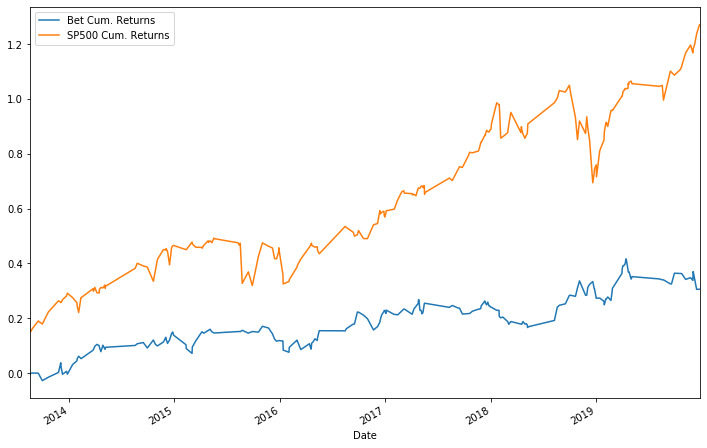

In [163]:
ROI, vol, mean_return, gains, bankroll = betting_strategy(championship='PL', init_capital=1000, max_odd=2.0, strategy='Constant', weight=0.01, a=1, max_loss=0.3, margin=0.01)

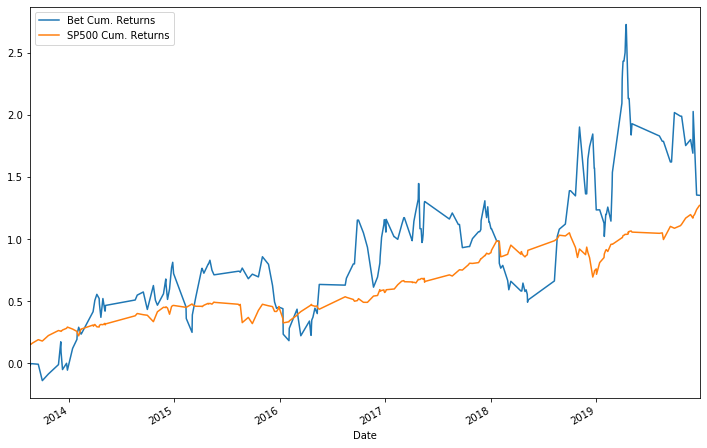

In [164]:
ROI, vol, mean_return, gains, bankroll = betting_strategy(championship='PL', init_capital=1000, max_odd=2.0, strategy='Constant', weight=0.05, a=1, max_loss=0.3, margin=0.01)

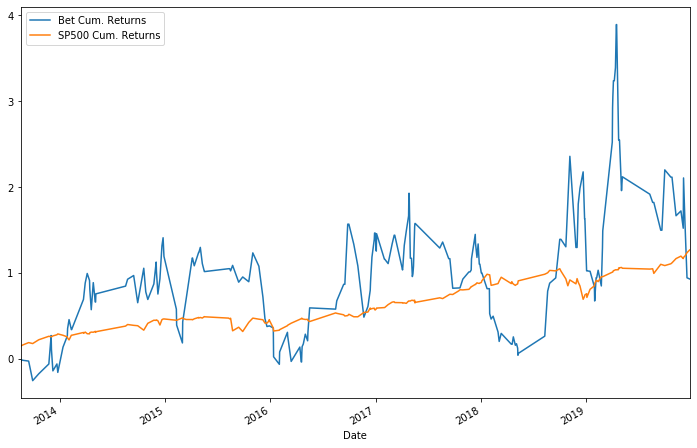

In [165]:
ROI, vol, mean_return, gains, bankroll = betting_strategy(championship='PL', init_capital=1000, max_odd=2.0, strategy='Constant', weight=0.09, a=1, max_loss=0.3, margin=0.01)

In [133]:
init_capital = 1000
cum_gains = []
for i in range(len(bankroll)):
    cum_gains.append((bankroll['Bankroll'].iloc[i]-init_capital)/init_capital)
    

In [148]:
bankroll.head(12)

,Bankroll,Cumulative Bet ROI
Date,,
2013-08-17,1000.000000,0.000000
2013-08-17,968.973747,-0.031026
2013-08-17,976.267098,-0.023733
2013-08-17,976.267098,-0.023733
2013-08-17,976.267098,-0.023733
2013-08-17,976.267098,-0.023733
2013-08-17,976.267098,-0.023733
2013-08-18,976.267098,-0.023733
2013-08-18,981.561417,-0.018439


In [154]:
cum_bets = bankroll[['Cumulative Bet ROI']].groupby(bankroll.index).last()

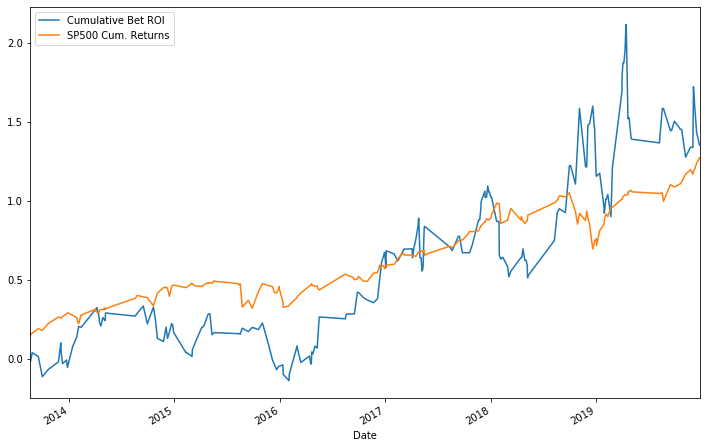

In [159]:
pd.merge(cum_bets, sp_cum_return, on='Date', how='right').dropna().plot()

In [152]:
sp_cum_return

,SP500 Cum. Returns
Date,
2013-01-02,0.025403
2013-01-03,0.023265
2013-01-04,0.028243
2013-01-07,0.025032
2013-01-08,0.021708
2013-01-09,0.024422
2013-01-10,0.032205
2013-01-11,0.032156
2013-01-14,0.031195


In [110]:
ROI

1.9743683256667268

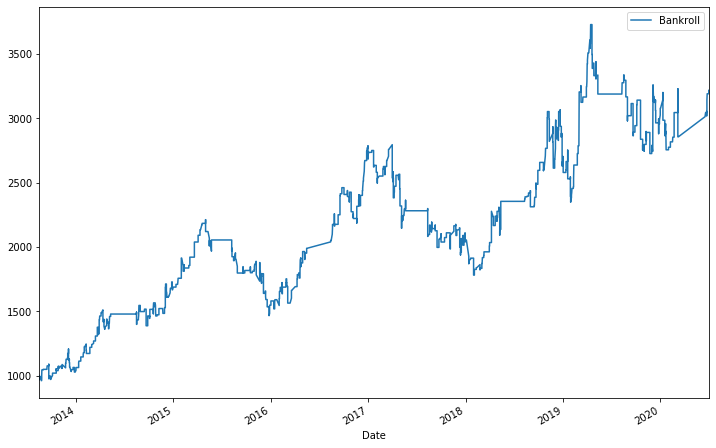

In [111]:
ROI, vol, mean_return, gains, bankroll = betting_strategy(championship='PL', init_capital=1000, max_odd=1.8, strategy='Varying', weight=5, a=1, max_loss=0.3, margin=0.02)

In [103]:
def import_data(ticker, start_date, end_date):
    import yfinance as yf
    data = yf.Ticker(ticker)
    data = data.history(period="max")
    data['Return'] = data['Close'].pct_change()
    data = data.loc[data.index >= start_date]
    data = data.loc[data.index <= end_date]
    
    return data

In [118]:
sp = import_data('^GSPC', '2013-01-01', '2020-01-01')[['Return']]
sp_cum_return = pd.DataFrame(data=np.cumprod(1 + sp['Return'].values) - 1, columns=['SP500 Cum. Returns'])
sp_cum_return.index = sp.index

array([0.02540335, 0.02326478, 0.02824308, ..., 1.27180109, 1.2586682 ,
       1.26532229])

In [120]:
sp_cum_return = pd.DataFrame(data=np.cumprod(1 + sp['Return'].values) - 1, columns=['SP500 Cum. Returns'])

In [123]:
sp_cum_return.index = sp.index

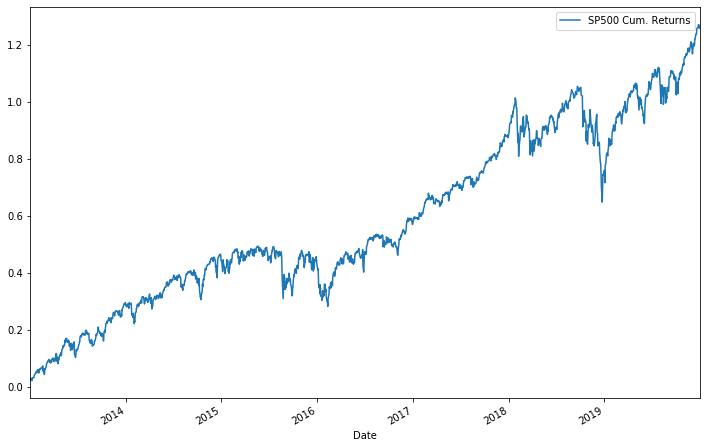

In [124]:
sp_cum_return.plot()

In [116]:
cum_return = [1+sp['Return'].iloc[0]]
for i in range(1,len(sp)):
    cum_return.append(1+sp['Return'].iloc[i]*cum_return[i-1])

In [117]:
cum_return

[1.0254033473800825,
 0.9978614350121652,
 1.0048547086678405,
 0.9968616919775388,
 0.9967677975634462,
 1.0026472850266412,
 1.0076175444989086,
 0.999952087310739,
 0.9990693696819974,
 1.0011276791373187,
 1.0001971874885898,
 1.005644078029125,
 1.0034224520596828,
 1.004443209016644,
 1.0015141751221308,
 1.00000669994297,
 1.0054455081799385,
 0.9981402442428673,
 1.0050965579269822,
 0.9960805073743829,
 0.9974467296376791,
 1.010026999184535,
 0.9883456112626062,
 1.0102950602880716,
 1.0005548537342528,
 0.9981935859913933,
 1.005647694250238,
 0.9993904884423456,
 1.0015942709553862,
 1.000593271716275,
 1.0006910492691077,
 0.9989541739944406,
 1.0073288671724634,
 0.9875049478179385,
 0.9937756393050663,
 1.0087179103886001,
 0.9815307983549197,
 1.0059966494989727,
 1.012802274087776,
 0.9991248154809366,
 1.0023218893432888,
 1.0046214288139923,
 1.0096101669593471,
 1.001094986315551,
 1.0018184487185418,
 1.004489259363794,
 1.0032637255941885,
 0.9975888972422137,
 1.

In [24]:
championship = 'PL'
data = pd.concat([pd.read_csv(championship+'2013.csv'), pd.read_csv(championship+'2014.csv'), 
                     pd.read_csv(championship+'2015.csv'), pd.read_csv(championship+'2016.csv'),
                     pd.read_csv(championship+'2017.csv'), pd.read_csv(championship+'2018.csv'),
                     pd.read_csv(championship+'2019.csv')], axis=0)

C:\Users\abellahsene\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [26]:
pd.read_csv(championship+'2013.csv')

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,17/08/13,Arsenal,Aston Villa,1,3,A,1,1,D,...,2.37,NaN,NaN,NaN,NaN,NaN,NaN,1.44,5.00,8.05
1,E0,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,...,2.02,NaN,NaN,NaN,NaN,NaN,NaN,1.42,4.62,10.19
2,E0,17/08/13,Norwich,Everton,2,2,D,0,0,D,...,1.82,NaN,NaN,NaN,NaN,NaN,NaN,3.81,3.27,2.21
3,E0,17/08/13,Sunderland,Fulham,0,1,A,0,0,D,...,1.77,NaN,NaN,NaN,NaN,NaN,NaN,2.52,3.23,3.16
4,E0,17/08/13,Swansea,Man United,1,4,A,0,2,A,...,1.98,NaN,NaN,NaN,NaN,NaN,NaN,3.62,3.41,2.22
5,E0,17/08/13,West Brom,Southampton,0,1,A,0,0,D,...,1.93,NaN,NaN,NaN,NaN,NaN,NaN,2.56,3.30,3.06
6,E0,17/08/13,West Ham,Cardiff,2,0,H,1,0,H,...,1.90,NaN,NaN,NaN,NaN,NaN,NaN,2.17,3.36,3.84
7,E0,18/08/13,Chelsea,Hull,2,0,H,2,0,H,...,2.45,NaN,NaN,NaN,NaN,NaN,NaN,1.23,6.80,16.25
8,E0,18/08/13,Crystal Palace,Tottenham,0,1,A,0,0,D,...,1.99,NaN,NaN,NaN,NaN,NaN,NaN,6.73,3.88,1.63
9,E0,19/08/13,Man City,Newcastle,4,0,H,2,0,H,...,2.30,NaN,NaN,NaN,NaN,NaN,NaN,1.26,6.41,14.02


(0.25059836087241, 0.7962639913808192, 0.05093023255813953)

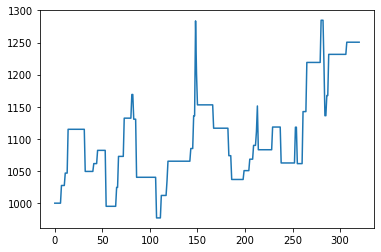

In [25]:
betting_strategy(championship='PL2019', init_capital=1000, max_odd=2.0, strategy='Varying', weight=5, a=1, max_loss=0.3, margin=0.05)

In [12]:
returns=[]
vols=[]
for years in list(np.arange(2013,2019)):
    path = 'PL' + str(years)
    ROI, vol, mean_return, gains, bankroll = betting_strategy(championship=path, init_capital=1000, max_odd=2.0, strategy='Varying', weight=0, 
                                             a=1, max_loss=0.3, margin=0.05)
    returns.append(bankroll)
#print('ROI: ' + str(np.mean(returns)), 'Volatility: ' + str(np.std(returns)))   
    

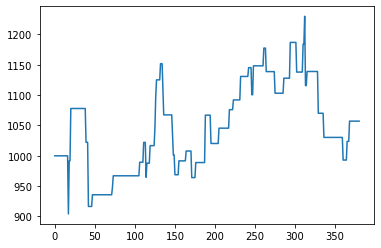

In [14]:
plt.plot(returns[0])